# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
import pandas as pd
import numpy as np

# train/val split
from sklearn.model_selection import StratifiedKFold, train_test_split

# for augmentation
!pip install nlpaug -q
import nlpaug.augmenter.word as naw
import random

# for model
import tensorflow as tf
!pip install transformers -q
import transformers
from transformers import TFRobertaModel, RobertaTokenizer
from sklearn.metrics import classification_report


# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.5 MB/s eta 0:00:00


# Get the data

cola_balanced_train.to_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_balanced_train.csv', index=False)
cola_validation.to_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_validation.csv', index=False)
cola_test.to_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_test.csv', index=False)

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_balanced_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_test.csv')



In [3]:
train_df.head()

,sentence,acceptability
0,To please John is tough.,1
1,John did not like Mary.,1
2,John is not more reliable a fellow than Bill.,0
3,Joan knew the answer.,1
4,The baby dressed.,1


In [4]:
val_df.head()

,sentence,acceptability
0,Which man did you talk to?,1
1,What she thought was that the poison was neutr...,1
2,The teacher made students happy.,1
3,I have sent 0 letter to Environmental Heath.,0
4,We believed to be omnipotent.,0


In [5]:
test_df.head()

,sentence,acceptability
0,The sailors rode the breeze clear of the rocks.,1
1,The weights made the rope stretch over the pul...,1
2,The mechanical doll wriggled itself loose.,1
3,"If you had eaten more, you would want less.",1
4,"As you eat the most, you want the least.",0


In [6]:
print("Number of acceptable/unacceptable sentences in training set")
print("-"*60)
train_df['acceptability'].value_counts()

Number of acceptable/unacceptable sentences in training set
------------------------------------------------------------


1    4802
0    4802
Name: acceptability, dtype: int64

In [7]:
print("Number of acceptable/unacceptable sentences in validation set")
print("-"*61)
val_df['acceptability'].value_counts()

Number of acceptable/unacceptable sentences in validation set
-------------------------------------------------------------


1    1221
0     490
Name: acceptability, dtype: int64

In [8]:
print("Number of acceptable/unacceptable sentences in test set")
print("-"*55)
test_df['acceptability'].value_counts()

Number of acceptable/unacceptable sentences in test set
-------------------------------------------------------


1    719
0    324
Name: acceptability, dtype: int64

In [9]:
acc = round(len(train_df[train_df['acceptability'] == 1]) / len(train_df)*100)
print(f'Percentage of training instances which are acceptable: {acc}%')

Percentage of training instances which are acceptable: 50%


In [10]:
acc = round(len(val_df[val_df['acceptability'] == 1]) / len(val_df)*100)
print(f'Percentage of validation instances which are acceptable: {acc}%')

Percentage of validation instances which are acceptable: 71%


In [11]:
acc = round(len(test_df[test_df['acceptability'] == 1]) / len(test_df)*100)
print(f'Percentage of test instances which are acceptable: {acc}%')

Percentage of test instances which are acceptable: 69%


# Train RoBERTa as a grammatical acceptability classifier on CoLA dataset

In [12]:
results = {}

In [13]:
results['all_acceptable'] = len(test_df[test_df['acceptability'] == 0]) / len(test_df)


## Load RoBERTa large



In [14]:
# Load tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
roberta_model = TFRobertaModel.from_pretrained('roberta-large')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [15]:
roberta_tokenizer

RobertaTokenizer(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [16]:
# Set global variables
MAX_LEN = 256

## Inspect the model

In [17]:
# output a sentence
trial_sentence = train_df['sentence'][7]
print("Trial sentence:",trial_sentence)
print("-"*100)

# tokenize it using the RoBERTa tokenizer # 10 token ids vs 8 tokens
tokenized_input = roberta_tokenizer(trial_sentence,return_tensors='tf')

print("Tokens:",tokenized_input)
print("-"*100)
print("BPE tokenization:",roberta_tokenizer.tokenize(trial_sentence))

Trial sentence: The car honked down the road.
----------------------------------------------------------------------------------------------------
Tokens: {'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[    0,   133,   512, 11006, 10916,   159,     5,   921,     4,
            2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
----------------------------------------------------------------------------------------------------
BPE tokenization: ['The', 'Ġcar', 'Ġhon', 'ked', 'Ġdown', 'Ġthe', 'Ġroad', '.']


In [18]:
roberta_output = roberta_model(tokenized_input)
roberta_output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 10, 1024), dtype=float32, numpy=
array([[[-2.53258944e-01, -1.14465296e-01, -1.02398098e-02, ...,
          1.17424890e-01,  8.66779685e-02,  1.61519408e-01],
        [ 1.42646834e-01, -4.98023219e-02, -3.83361012e-01, ...,
          3.89015265e-02,  1.40818208e-02,  1.20361291e-01],
        [-4.55874652e-02,  1.56140566e-01, -2.06102595e-01, ...,
         -1.09004661e-01,  9.05206352e-02,  8.94598886e-02],
        ...,
        [ 1.16132043e-01,  5.44511974e-02, -2.00156733e-01, ...,
         -4.26657014e-02,  4.38294113e-02,  2.15332564e-02],
        [ 1.79594830e-02,  5.95539212e-02,  3.67381796e-03, ...,
         -4.98286113e-02,  1.82859242e-01,  4.70421687e-02],
        [ 9.66567360e-03,  1.66181959e-02,  1.91613995e-02, ...,
         -8.33375454e-02,  1.22566789e-01, -3.69705260e-04]]],
      dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[ 0.08998735, 

In [19]:
print(len(roberta_output))

2


In [20]:
# last_hidden_state
roberta_output[0] # shape=(1, 10, 1024)

<tf.Tensor: shape=(1, 10, 1024), dtype=float32, numpy=
array([[[-2.53258944e-01, -1.14465296e-01, -1.02398098e-02, ...,
          1.17424890e-01,  8.66779685e-02,  1.61519408e-01],
        [ 1.42646834e-01, -4.98023219e-02, -3.83361012e-01, ...,
          3.89015265e-02,  1.40818208e-02,  1.20361291e-01],
        [-4.55874652e-02,  1.56140566e-01, -2.06102595e-01, ...,
         -1.09004661e-01,  9.05206352e-02,  8.94598886e-02],
        ...,
        [ 1.16132043e-01,  5.44511974e-02, -2.00156733e-01, ...,
         -4.26657014e-02,  4.38294113e-02,  2.15332564e-02],
        [ 1.79594830e-02,  5.95539212e-02,  3.67381796e-03, ...,
         -4.98286113e-02,  1.82859242e-01,  4.70421687e-02],
        [ 9.66567360e-03,  1.66181959e-02,  1.91613995e-02, ...,
         -8.33375454e-02,  1.22566789e-01, -3.69705260e-04]]],
      dtype=float32)>

In [21]:
# cls token (as per BERT) Which one should we use?????
cls_token = roberta_output[0][:, 0, :]
print("using BERT's cls sample token from notebook",cls_token)
print("last_hidden_state",roberta_output.last_hidden_state)

using BERT's cls sample token from notebook tf.Tensor(
[[-0.25325894 -0.1144653  -0.01023981 ...  0.11742489  0.08667797
   0.16151941]], shape=(1, 1024), dtype=float32)
last_hidden_state tf.Tensor(
[[[-2.53258944e-01 -1.14465296e-01 -1.02398098e-02 ...  1.17424890e-01
    8.66779685e-02  1.61519408e-01]
  [ 1.42646834e-01 -4.98023219e-02 -3.83361012e-01 ...  3.89015265e-02
    1.40818208e-02  1.20361291e-01]
  [-4.55874652e-02  1.56140566e-01 -2.06102595e-01 ... -1.09004661e-01
    9.05206352e-02  8.94598886e-02]
  ...
  [ 1.16132043e-01  5.44511974e-02 -2.00156733e-01 ... -4.26657014e-02
    4.38294113e-02  2.15332564e-02]
  [ 1.79594830e-02  5.95539212e-02  3.67381796e-03 ... -4.98286113e-02
    1.82859242e-01  4.70421687e-02]
  [ 9.66567360e-03  1.66181959e-02  1.91613995e-02 ... -8.33375454e-02
    1.22566789e-01 -3.69705260e-04]]], shape=(1, 10, 1024), dtype=float32)


In [22]:
# pooler_output
roberta_output[1] # shape=(1,1024)

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[ 0.08998735,  0.6145433 , -0.06057784, ...,  0.11102981,
         0.67505187, -0.49593568]], dtype=float32)>

## Tokenize the inputs

In [23]:
# train
x_train = roberta_tokenizer(train_df['sentence'].tolist(),
                            max_length=MAX_LEN,
                            truncation=True,
                            padding='max_length',
                            return_token_type_ids=True,
                            return_tensors='tf')

roberta_train_inputs = [x_train.input_ids,
                        x_train.token_type_ids,
                        x_train.attention_mask]

y_train = np.array(train_df['acceptability'].tolist())





# validation
x_val = roberta_tokenizer(val_df['sentence'].tolist(),
                           max_length=MAX_LEN,
                           truncation=True,
                           padding='max_length',
                           return_token_type_ids=True,
                           return_tensors='tf')

roberta_val_inputs = [x_val.input_ids,
                      x_val.token_type_ids,
                       x_val.attention_mask]

y_val = np.array(val_df['acceptability'].tolist())





# test
x_test = roberta_tokenizer(test_df['sentence'].tolist(),
                           max_length=MAX_LEN,
                           truncation=True,
                           padding='max_length',
                           return_token_type_ids=True,
                           return_tensors='tf')

roberta_test_inputs = [x_test.input_ids,
                       x_test.token_type_ids,
                       x_test.attention_mask]

y_test = np.array(test_df['acceptability'].tolist())


In [24]:
x_train.input_ids[0]

<tf.Tensor: shape=(256,), dtype=int32, numpy=
array([   0, 3972, 2540,  610,   16, 1828,    4,    2,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
     

## Define the model

In [25]:
# mine
def create_roberta_classification_model(roberta_model,
                                        num_unfreeze=0,
                                        hidden_size_1 = 1024, # size of the incoming layer
                                        hidden_size_2 = 512,  # half the size of the incoming layer
                                        dropout=0.3,
                                        learning_rate=0.00005):
    """
    Build a simple classification model with RoBERTa.
    Use the CLS Output for classification purposes.
    Inputs = input_ids, attention_mask
    Layers = cls token, 2 hidden layers, 2 dropout layers
    Outputs = binary classification
    """
    #roberta_model.trainable = True

    if num_unfreeze == 0:
      roberta_model.trainable = False
    elif num_unfreeze == 24:
      roberta_model.trainable = True
    else:
      retrain_layers = []

      for retrain_layer_number in range(num_unfreeze):
        layer_code = '_' + str(23 - retrain_layer_number)
        retrain_layers.append(layer_code)

      print('retrain layers: ', retrain_layers)

      for w in roberta_model.weights:
        if not any([x in w.name for x in retrain_layers]):
          w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                      'token_type_ids': token_type_ids,
                      'attention_mask': attention_mask}

    roberta_out = roberta_model(roberta_inputs)

    # cls token (then add a loop to put an option for pooler token)
    cls_token = roberta_out[0][:, 0, :]
    #pooler_token = roberta_out[1]

    # hidden layer 1
    hidden_1 = tf.keras.layers.Dense(hidden_size_1, activation='relu', name='hidden_layer_1')(cls_token)

    # dropout layer 1
    hidden_1 = tf.keras.layers.Dropout(dropout, name='dropout_layer_1')(hidden_1)

    # hidden layer 2 (not sure if this is kosher, to split size in 2)
    hidden_2 = tf.keras.layers.Dense(hidden_size_2, activation='relu', name='hidden_layer_2')(hidden_1)

    # dropout layer 2
    hidden_2 = tf.keras.layers.Dropout(dropout, name='dropout_layer_2')(hidden_2)

    # classification layer
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden_2)

    # classification model
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')


    return classification_model

## roberta_large_1
- roberta-large
- cls_token = roberta_out[0][:, 0, :]
- fully trainable
- hidden_size=200
- dropout=0.3
- learning_rate=0.000005
- batch_size=4
- epochs=3
- 2 hidden layers
- 2 dropout layers
- second hidden layer half the size of first

### Build

In [36]:
checkpoint = 'roberta-large'
model = TFRobertaModel.from_pretrained(checkpoint)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [37]:
model_1 = create_roberta_classification_model(model, num_unfreeze=0)

In [38]:
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                    

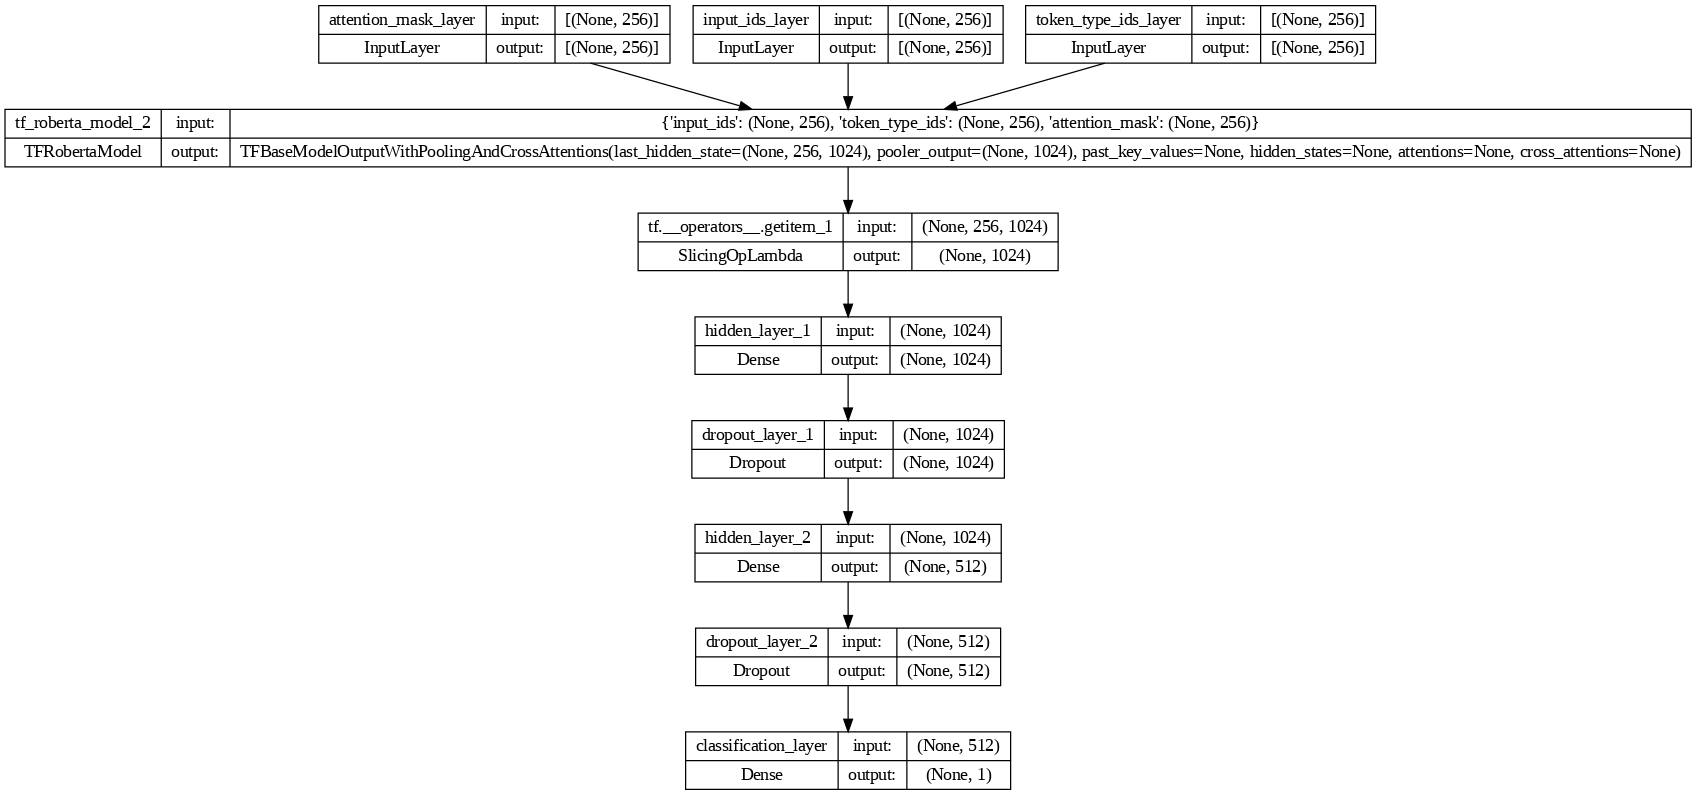

In [39]:
tf.keras.utils.plot_model(model_1, show_shapes=True, dpi=90)

### Fit

In [40]:
model_history = model_1.fit(roberta_train_inputs,
                          y_train,
                          validation_data=(roberta_val_inputs, y_val),
                          batch_size=32,
                          epochs=3
                          )

Epoch 1/3
301/301 [==============================] - 723s 2s/step - loss: 0.7339 - accuracy: 0.5255 - val_loss: 0.6858 - val_accuracy: 0.5435
Epoch 2/3
301/301 [==============================] - 688s 2s/step - loss: 0.6769 - accuracy: 0.5831 - val_loss: 0.5720 - val_accuracy: 0.7171
Epoch 3/3
301/301 [==============================] - 688s 2s/step - loss: 0.6343 - accuracy: 0.6378 - val_loss: 0.5565 - val_accuracy: 0.7329


### Visualize

In [41]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

  # loss
  axes[0].plot(model_history.history['loss'], color='darkturquoise', label='train_losses')
  axes[0].plot(model_history.history['val_loss'], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss')
  axes[0].legend()

  # accuracy
  axes[1].plot(model_history.history['accuracy'], color='darkturquoise', label='train_accuracy')
  axes[1].plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy')
  axes[1].legend()

  plt.show()

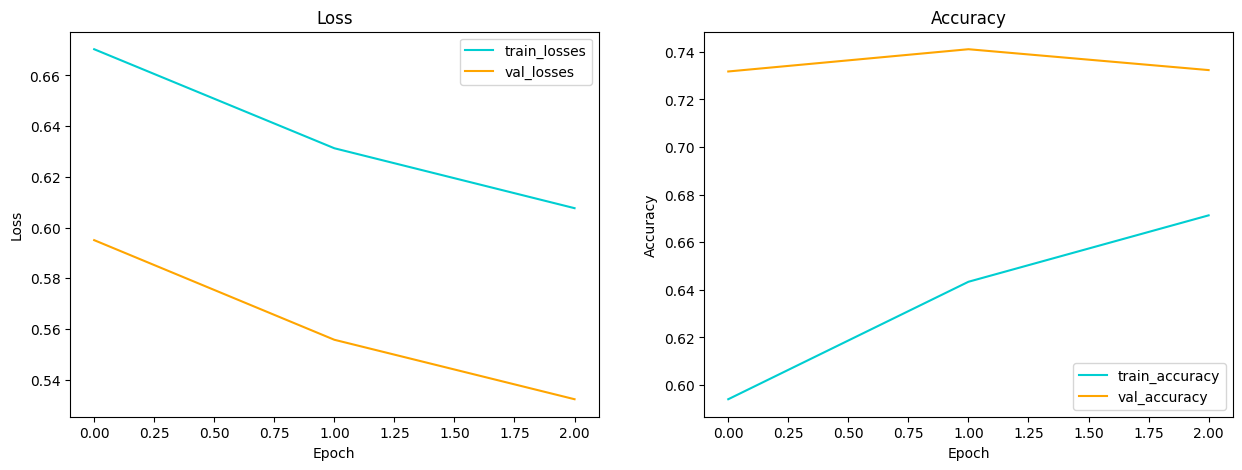

In [33]:
visualize(model_history)

## roberta_large_2
- roberta-large
- last_hidden_state[:, 0, :]
- hidden_size=200
- dropout=0.1
- hidden layer size: [1024,512]
- learning_rate=0.00005
- batch_size=32
- epochs=3


### Build

In [62]:
checkpoint = 'roberta-large'
model = TFRobertaModel.from_pretrained(checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [63]:
model_2 = create_roberta_classification_model(model, num_unfreeze=0, dropout=0.1)

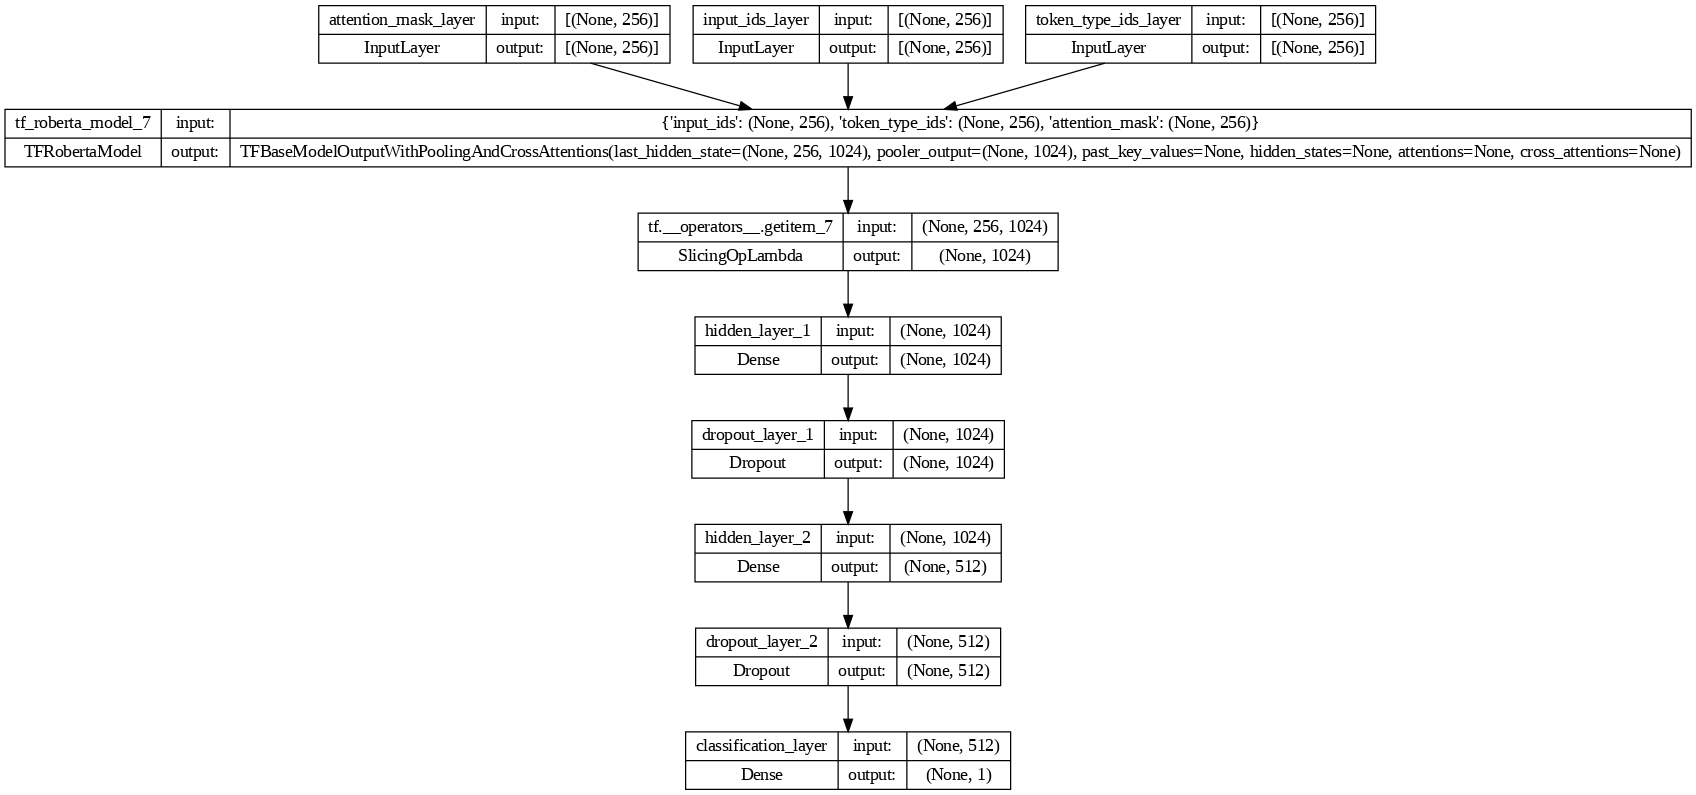

In [64]:
tf.keras.utils.plot_model(model_2, show_shapes=True, dpi=90)

### Fit

In [65]:
model_2_history = model_2.fit(roberta_train_inputs,
                          y_train,
                          validation_data=(roberta_val_inputs, y_val),
                          batch_size=32,
                          epochs=3
                          )

Epoch 1/3
301/301 [==============================] - 662s 2s/step - loss: 0.6766 - accuracy: 0.5693 - val_loss: 0.5731 - val_accuracy: 0.7177
Epoch 2/3
301/301 [==============================] - 632s 2s/step - loss: 0.6170 - accuracy: 0.6606 - val_loss: 0.5690 - val_accuracy: 0.7703
Epoch 3/3
301/301 [==============================] - 632s 2s/step - loss: 0.5755 - accuracy: 0.7063 - val_loss: 0.5473 - val_accuracy: 0.7884


### Visualize

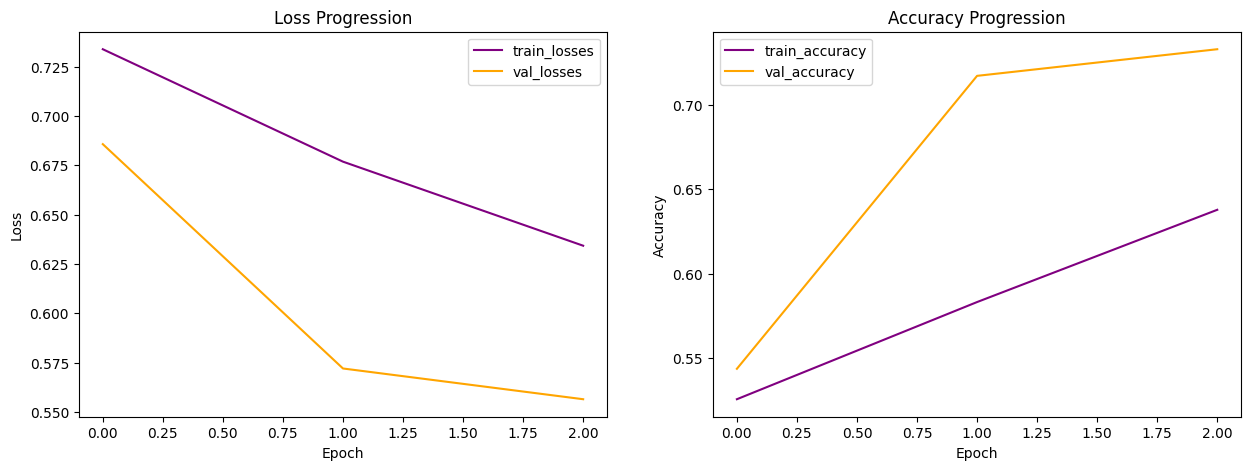

In [67]:
visualize(model_history)

## roberta_large_3


```
max_len,Num_unfreeze,hidden_size,dropout,Learning Rate,Batch_size,Epochs
```

```
256,4,"[1024,512]",0.1,0.0000005,4,6
```


### Build

In [68]:
checkpoint = 'roberta-large'
model = TFRobertaModel.from_pretrained(checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [71]:
model_3 = create_roberta_classification_model(model, num_unfreeze=4, dropout=0.1, learning_rate = 0.0000005)

retrain layers:  ['_23', '_22', '_21', '_20']


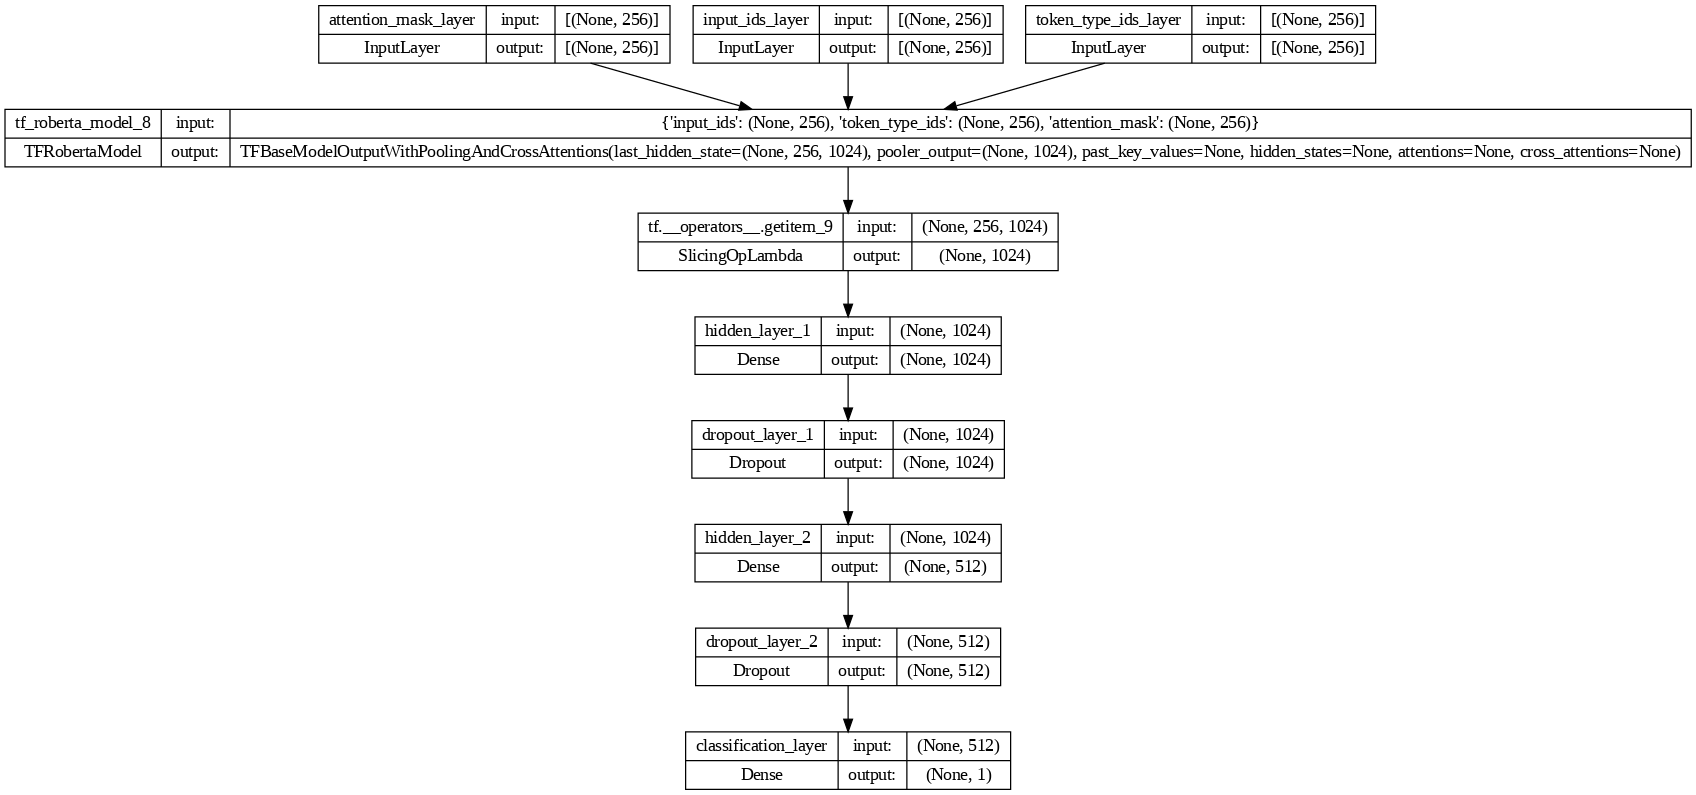

In [72]:
tf.keras.utils.plot_model(model_3, show_shapes=True, dpi=90)

### Fit

In [73]:
model_3_history = model_3.fit(roberta_train_inputs,
                          y_train,
                          validation_data=(roberta_val_inputs, y_val),
                          batch_size=4,
                          epochs=6
                          )

Epoch 1/6
2401/2401 [==============================] - 723s 297ms/step - loss: 0.7315 - accuracy: 0.4942 - val_loss: 0.6991 - val_accuracy: 0.3869
Epoch 2/6
2401/2401 [==============================] - 710s 296ms/step - loss: 0.7066 - accuracy: 0.5134 - val_loss: 0.7053 - val_accuracy: 0.3431
Epoch 3/6
2401/2401 [==============================] - 710s 296ms/step - loss: 0.7050 - accuracy: 0.5208 - val_loss: 0.6810 - val_accuracy: 0.6447
Epoch 4/6
2401/2401 [==============================] - 709s 295ms/step - loss: 0.6998 - accuracy: 0.5310 - val_loss: 0.6900 - val_accuracy: 0.4892
Epoch 5/6
2401/2401 [==============================] - 710s 296ms/step - loss: 0.6986 - accuracy: 0.5261 - val_loss: 0.6716 - val_accuracy: 0.7078
Epoch 6/6
2401/2401 [==============================] - 709s 295ms/step - loss: 0.6928 - accuracy: 0.5415 - val_loss: 0.6751 - val_accuracy: 0.6914


### Visualize

In [ ]:
visualize(model_3_history)